### **4.2 Deflusso dunniano**

Si analizza il fenomeno del deflusso superficiale di tipo dunniano prendendo in considerazione la terza colonna di suolo del notebook "2.Profilo_stratigrafico".

#### **Introduzione teorica**

Il deflusso dunniano è una tipologia di deflusso superficiale che si basa su un processo di saturazione dal basso verso l'alto.
In presenza di una precipitazione e di uno strato poco permeabile si ha in primo luogo, la formazione della falda in profondità e successivamente la risalita della stessa. Quando la falda raggiunge la superficie si ha la formazione di ponding e ruscellamento.

Tale fenomeno è descritto dalla seguente formula:
$$J(t) < \big|K(\theta w)\dfrac{\partial \psi}{\partial z} + K(\theta w)\big| $$
dove:

- $J(t)$ : intensità di precipitazione;
- $\theta w$ : contenuto d'acqua;
- $K(\theta w)$ : conducibilità idraulica riferita al momento della precipitazione;
- ${\partial \psi}/{\partial z}$ : gradiente della suzione lungo l'asse z.


Questo meccanismo è favorito dalle seguenti condizioni:

- elevata permeabilità del suolo;
- copertura vegetale;
- alte temperature.

Il deflusso dunniano è legato ai volumi di precipitazione e quindi alla somma di più precipitazioni consecutive.

La colonna di suolo presa in analisi è la terza (presentata nel notebook "2.Profilo_stratigrafico").

--- 

#### **Definizione della griglia**


**- grid_input_file_name** :  `/data/Grid_input/dati_colonna3_VG.csv`

**- ic_input_file_name** :  `/data/Grid_input/dati_colonna3_IC.csv`

**- parameter_input_file_name** : `/data/Grid_input/Richards_VG.csv`

**- grid_type** :`exponential`

**- dz_min** (spessore del primo layer) : `0.01`

**- b** (tasso di crescita) : `0.01`     

**- psi_interp_model** : `linear`

**- T_interp_model** : `linear`

**- output_file_name** : `/data/Grid_NetCDF/colonna3_Grid_2.nc`

---

#### **Creazione della griglia**

In [1]:
import os
import pandas as pd
from geoframepy.whetgeo1d import grid_creator
from geoframepy.whetgeo1d import grid_to_netcdf
import warnings
warnings.filterwarnings('ignore')

project_path = os.path.dirname(os.getcwd())

grid_input_file_name = project_path + "/data/Grid_input/dati_colonna3_VG.csv"
ic_input_file_name = project_path + "/data/Grid_input/dati_colonna3_IC.csv"
parameter_input_file_name = project_path + "/data/Grid_input/Richards_VG.csv"
dictionary_input_file_name = project_path + "/data/Grid_input/dictionary.csv"
grid_type = 'exponential'

dz_min = 0.01 
dz_max = -9999 
b = 0.01     

psi_interp_model = "linear"
T_interp_model = "linear"
water_ponding_0 = -1.5
T_water_ponding_0 = 278.15

output_file_name =  project_path + "/data/Grid_NetCDF/colonna3_Grid_1.nc"
output_title = '''Griglia di calcolo per colonna 3 simulazione 1.
                  '''
output_summary = '''

'''
output_date = ''
output_institution = 'GEOframe'

In [2]:
data_grid = pd.read_csv(grid_input_file_name)

data_ic = pd.read_csv(ic_input_file_name)

data_parameter = pd.read_csv(parameter_input_file_name, comment='#')

data_dictionary = pd.read_csv(dictionary_input_file_name)

[KMAX, eta, eta_dual, space_delta, z, z_dual, control_volume] = grid_creator.grid1D(data_grid, dz_min, b, dz_max, grid_type, shallow_water=True)

[psi_0, T_0] = grid_creator.set_initial_condition(data_ic, eta, psi_interp_model, T_interp_model, water_ponding_0=water_ponding_0, T_water_ponding_0=T_water_ponding_0, shallow_water=True)

control_volume_index = grid_creator.calibration_point_index(data_grid, eta)

[equation_state_ID, parameter_ID, theta_s, theta_r, par_1, par_2, par_3, par_4,
par_5, alpha_ss, beta_ss, ks] = grid_creator.set_parameters_richards(data_grid, data_parameter, data_dictionary, KMAX, eta)

grid_to_netcdf.write_grid_netCDF_richards(eta, eta_dual, z, z_dual, space_delta, control_volume, control_volume_index, psi_0, T_0, equation_state_ID, parameter_ID, KMAX,
                  theta_s, theta_r, par_1, par_2, par_3, par_4, par_5, alpha_ss, beta_ss, ks,
                  output_file_name, output_title, output_institution, output_summary, output_date, grid_input_file_name, parameter_input_file_name)



***SUCCESS writing!  C:\Users\User\Desktop\OMS_Project_WHETGEO1D_Idrologia_ay_21_22/data/Grid_NetCDF/colonna3_Grid_1.nc


---
#### **Definizione dei parametri e delle condizioni al contorno**

Dopo aver creato il file netCDF relativo alla griglia, si prosegue con la simulazione utilizzando il simfile WHETGEO1D_sim5.sim, che permette di risolvere il problema di Richards. In tale file sono stati utilizzati i seguenti parametri :

- parametrizzazione della SWRC : **Van Genuchten**
- condizione al contorno sulla superficie : **Coupled**
- condizione al contorno al fondo : **Dirichlet** -> fondo impermeabile
- modello che tiene conto della temperatura del suolo: **Ronan1998**
- limite superiore al ponding: **assente (0)**
- data d'inizio della simulazione: **23/12/2020 00:00**
- data di fine della simulazione: **27/12/2020 00:00**
- timestep : **5 (ogni 5 minuti)**

---


#### **Post-processing**

#### Librerie

In [3]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
import matplotlib.style as style 
import matplotlib.colors as cl
import matplotlib.dates as mdates
import matplotlib
from geoframepy.timeseries import io_csv
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

style.available
style.use('seaborn-whitegrid')

nice_fonts = {
        "legend.frameon": True,
        "legend.fancybox": True,
        "legend.facecolor": "white",
        "axes.edgecolor": "0.8",
        "axes.linewidth": 0.6,
        "grid.linewidth": 0.3,
        "text.usetex": False,
        "font.family": "serif",
        "axes.labelsize": 17,
        "font.size": 18,
        "legend.fontsize": 16,
        "xtick.labelsize": 17,
        "ytick.labelsize": 17,
}

my_cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ['#ffffd9','#edf8b1','#c7e9b4','#7fcdbb','#41b6c4','#1d91c0','#225ea8','#253494','#081d58'])
colors = ['#e41a1c','#377eb8','#4daf4a','#984ea3','#ff7f00','#ffff33','#a65628']
plt.rcParams.update(nice_fonts)

#### Visualizzazione del file di output

In [4]:
ds5 = xr.open_dataset(project_path + '/output/sim5_DD_0000.nc')
ds5

<xarray.Dataset>
Dimensions:           (depth: 94, dualDepth: 94, time: 1153)
Coordinates:
  * depth             (depth) float64 -1.499 -1.485 -1.461 ... -0.005 0.0
  * dualDepth         (dualDepth) float64 -1.5 -1.498 -1.473 ... -0.01 0.0
  * time              (time) datetime64[ns] 2020-12-23 ... 2020-12-27
Data variables:
    psi               (time, depth) float64 ...
    psiIC             (depth) float64 ...
    T                 (depth) float64 ...
    theta             (time, depth) float64 ...
    saturationDegree  (time, depth) float64 ...
    darcyVelocity     (time, dualDepth) float64 ...
    waterVolume       (time, depth) float64 ...
    error             (time) float64 ...
    topBC             (time) float64 ...
    bottomBC          (time) float64 ...
    runOff            (time) float64 ...
    controlVolume     (depth) float64 ...
Attributes:
    Description_of_the_problem:         WHETGEO-1D ex03 wet initial condition.
    Top_boundary_condition:             Top Coupled
    Bottom_boundary_condition:          Bottom Dirichlet
    path_top_boundary_condition:        C:\Users\ENRICO GIRARDI\Desktop\OMS_P...
    path_bottom_boundary_condition:     C:\Users\ENRICO GIRARDI\Desktop\OMS_P...
    path_grid:                          C:\Users\ENRICO GIRARDI\Desktop\OMS_P...
    time_delta:                          
    swrc_model:                         {Water Depth,Van Genuchten}
    soil_hydraulic_conductivity_model:  {null,Mualem Van Genuchten}
    interface_conductivity_model:       max

#### Analisi della precipitazione

In [8]:
data = pd.read_csv('dati pluviometrici 3.csv',sep=',',usecols=[1,2])

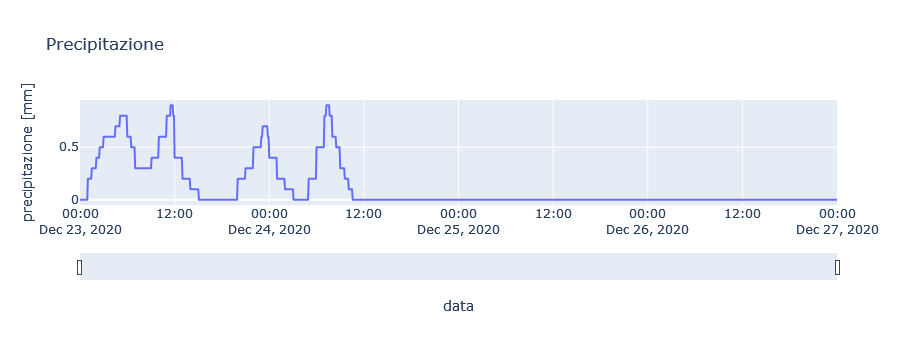

In [9]:
import plotly.express as px
%matplotlib inline 

fig = px.line(data,x='data', y='precipitazione [mm]',title='Precipitazione') 
fig.update_xaxes(rangeslider_visible=True)
fig.show()

#### Confronto tra infiltrazione e precipitazione

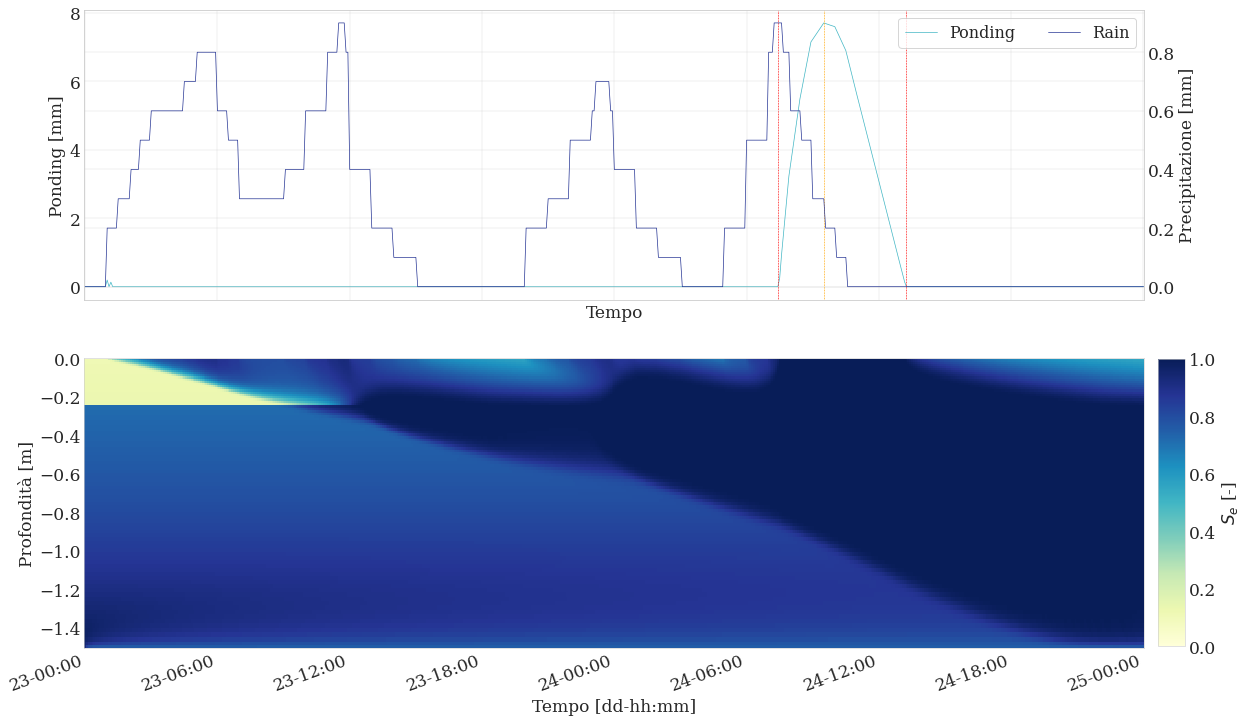

In [7]:
start_date = '2020-12-23 00:00'
end_date = '2020-12-25 00:00'

line_w = 0.7
plot_width = 19

fig, ax = plt.subplots(2, 1, sharex='col', gridspec_kw={'height_ratios': [1,1]}, figsize=(plot_width,plot_width/1.618))

lns1 = ax[0].plot(ds5.time.sel(time=slice(start_date, end_date)).values, 
                  ds5.waterVolume.sel(depth=0).sel(time=slice(start_date,end_date))*1000, label='Ponding', color='#41b6c4', linewidth=line_w)
ax0twin = ax[0].twinx()
lns2 = ax0twin.plot(ds5.time.sel(time=slice(start_date, end_date)).values, 
                    ds5.topBC.sel(time=slice(start_date,end_date)), label='Rain', linewidth=line_w, color='#253494')

ax0twin.set_ylabel('Precipitazione [mm]')
ax[0].set_xlabel('Tempo')
ax[0].set_ylabel('Ponding [mm]')

lns = lns1+lns2
labs = [l.get_label() for l in lns]
ax[0].legend(lns, labs, loc='upper right', ncol=2)

ax[0].axvline(x=ds5.time.sel(time='2020-12-24 07:25').values, linewidth=0.8, linestyle=(0, (1, 1)), color='red')
ax[0].axvline(x=ds5.time.sel(time='2020-12-24 09:30').values, linewidth=0.8, linestyle=(0, (1, 1)), color='orange')
ax[0].axvline(x=ds5.time.sel(time='2020-12-24 13:15').values, linewidth=0.8, linestyle=(0, (1, 1)), color='red')

norm = matplotlib.colors.Normalize(vmin=0, vmax=1)
im = ds5.saturationDegree.where(ds5.depth<0.0).sel(time=slice(start_date, end_date)).plot(ax=ax[1], y='depth', add_colorbar=False, cmap=my_cmap, norm=norm)

ax[1].set_ylabel('Profondità [m]')
ax[1].set_xlabel('Tempo [dd-hh:mm]')

cbaxes = fig.add_axes([0.91, 0.127, 0.02, 0.34]) 
cbar = fig.colorbar(im, ax=ax[1], orientation="vertical", fraction=0.1, pad=0.1, cax=cbaxes, label='$S_e$ [-]')

ax[1].xaxis.set_major_formatter(mdates.DateFormatter('%d-%H:%M'))
ax[1].xaxis.set_tick_params(rotation=20)

plt.show()

 **Commenti ai grafici**

Nel grafico 1D si osservano 3 distinti eventi di precipitazione successivi. Tale distinzione la si può riscontrare anche nel grafico 2D in quanto sono distinguibili tre differenti profili d'infiltrazione con tre differenti picchi di contenuto relativo d'acqua.

In corrispondenza del picco del terzo evento di precipitazione (ore 07:25 del 24/12) si ha l'inizio dello sviluppo del ponding; tale fenomeno raggiunge il valore massimo di 7.5 [mm] alle ore 09:30 (linea arancione) e termina alle 13:15. In presenza di ponding superficiale si riscontra la saturazione della colonna di suolo, evidenziata anche da un contenuto relativo d'acqua unitario  (contenuto d'acqua pari alla porosità).

In corrispondenza del termine del fenomeno del ponding (causato dal mancato apporto d'acqua dalla superficie) si ha un approfondimento del fronte di saturazione.

Confrontando i grafici relativi alle due differenti tipologie di deflusso si evince che il deflusso dunniano risulta essere superiore all'hortoniano in quanto lo spessore del ponding è maggiore.
   
---